# OUTLIER DETECTION

### Identify the top 1% outliers. 

** Dataset: ** the same one used for classification. 

** Objective: ** adopt at least two different methods belonging to different families (i.e. model-based, distance-based, density-based, angle-based, …) to identify the 1% of input records with the highest likelihood of being outliers, and compare the results. 

** IMPORT LIBRARIES **

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import seaborn as sns

import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix

import scipy.spatial as spatial
from scipy.spatial import ConvexHull
from scipy.stats import itemfreq
from scipy.stats import chi2

import sklearn.metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor

from itertools import combinations as comb

from operator import add

from pyod.models.abod import ABOD

** READ THE DATASET **

In [2]:
df = pd.read_csv("abalone.csv") 

** DATA PREPARATION **

We decided to remove the Infant records anyway, so that we would work on the same dataset, and we can use the information gained from classification and the other way around.

In [3]:
df = df[df["Sex"] != "I"]

We perform the same data preparation: we discretize Sex, we rename all the variables and we create the variable Volume.

In [4]:
s = sorted(df['Sex'].unique())
genders_mapping = dict(zip(s, range(0, len(s) + 1)))
df['Sex'] = df['Sex'].map(genders_mapping).astype(int)


df["Length"] = df[" Length"]*200
del df[" Length"]

df["Diameter"] = df[" Diameter"]*200
del df[" Diameter"]

df["Height"] = df[" Height"]*200
del df[" Height"]

df["Volume"] = df["Length"]*df["Diameter"]*df["Height"]

df["WholeWeight"] = df[" WholeWeight"]*200
del df[" WholeWeight"]

df["ShuckedWeight"] = df[" ShuckedWeight"]*200
del df[" ShuckedWeight"]

df["VisceraWeight"] = df[" VisceraWeight"]*200
del df[" VisceraWeight"]

df["ShellWeight"] = df[" ShellWeight"]*200
del df[" ShellWeight"]

df["Rings"] = df[" Rings"]
del df[" Rings"]

In this case we don't discretize the attribute Rings in two classes because we want to understand also if there are some odd Ring values that maybe were wrongly classified in the previous analysis.

In [5]:
print "The dataset has", df.shape[0], "rows, so the 1% of outliers are", df.shape[0]/100

The dataset has 2835 rows, so the 1% of outliers are 28


We draw the scatter plot of all the possible varibles combination in order to understand which distributions may be the sparser.

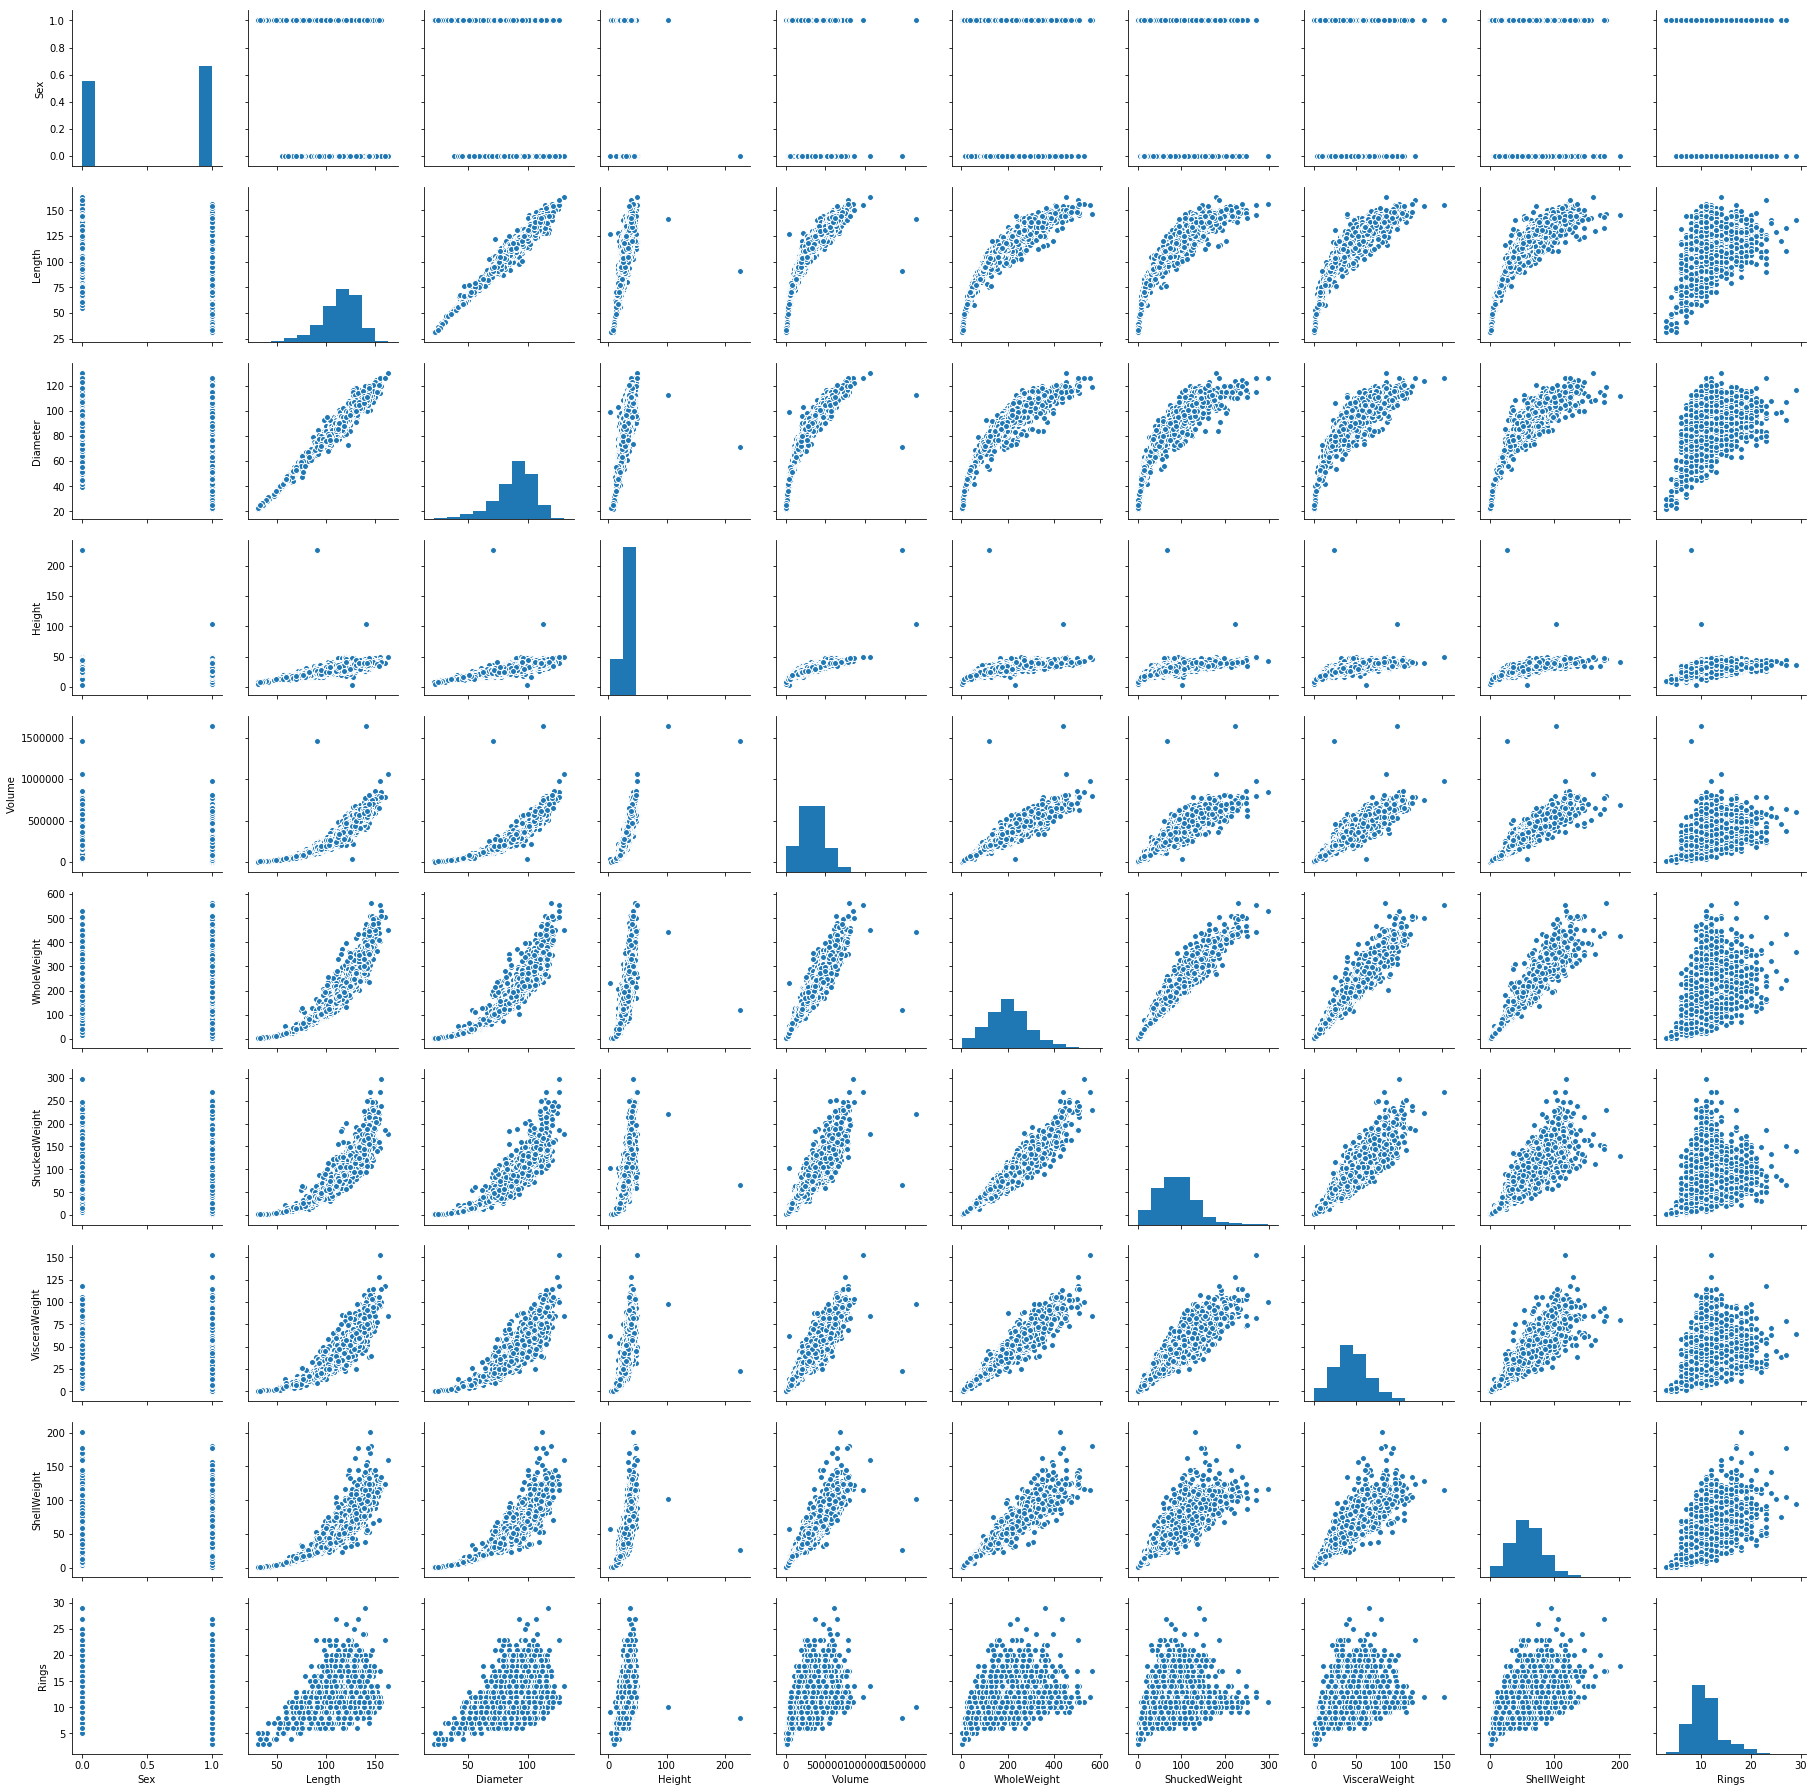

In [6]:
sns.pairplot(df)

We plot the scatter matrix for just some variables to have a more accurate look at what the outliers might be.

In [7]:
df2 = df.copy()

In [8]:
R = pd.cut(df2['Rings'], 9, labels = ['3-5', '6-8', '9-11', '12-14', '15-17', '18-20', '21-23', '24-26', '27-29'])
df2['Rings'] = R

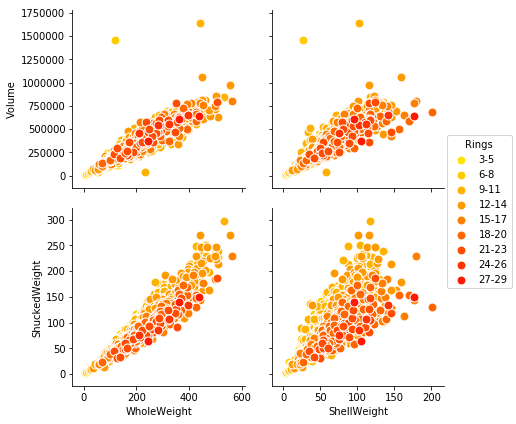

In [9]:
pair = sns.pairplot(df2, hue="Rings", size=3, plot_kws={"s": 80}, x_vars=["WholeWeight", "ShellWeight"], y_vars=["Volume", "ShuckedWeight"], palette="autumn_r")

#plt.savefig('Images/Outliers/Scatter.png', format='png', bbox_inches='tight')

However we stil normalize all the variables so that every value is in the range [0, 1] and outliers methods based on the distance returns more accurate results.

In [10]:
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df=pd.DataFrame(x_scaled, columns=df.columns)

The distributions are quite compact, the values distant from the others are very few.

Let's begin with the different classes of outliers detection methods

## STATISTICAL APPROACH - MAHALANOBIS DISTANCE

Given a certain kind of statistical distribution (e.g., Gaussian), compute the parameters assuming all data points have been
generated by such a statistical distribution (e.g., mean). Outliers are points that have a low probability to be generated by the overall distribution (e.g., deviate more than 3 times the standard deviation from the mean)

The Mahalanobis Distance can be computed as $ MD = \sqrt{  (x - \mu)^T {\rm \bf  \Sigma}^{-1} (x - \mu)}$ where:
- x is out dataset;
- $x - \mu $ is our dataset where to each column we subtrack $ \mu $ which is the relative mean of each column. This way the mean in each column is 0;
- $\Sigma$ is the matrix of covariance of out dataset.

First of all let's compute the covariance of the dataset and then compute the inverse. Note that if rowvar is True, then each row represents a variable, with observations in the columns.

In [11]:
cov_df = np.cov(df,rowvar = False) 
inv_cov = np.linalg.inv(cov_df)
inv_cov.shape

(10L, 10L)

For each column, compute the mean and subtrack it element wise from the column

In [12]:
list_mean0 = []
for col in df:
    col_mean0 = df[col] - np.mean(df[col])
    list_mean0.append(col_mean0)

Convert the list to a numpy array and transpose it to have the columns

In [13]:
df_mean0 = np.transpose(np.array(list_mean0))
(df_mean0).shape

(2835L, 10L)

Now we can compute the MD of our dataset

In [14]:
MD = []
for i in range(len(df_mean0)):
    dot_prod = np.sqrt(np.dot(np.dot(np.transpose(df_mean0[i]),inv_cov),df_mean0[i]))
    MD.append(dot_prod)

The simplest way to find outliers is to set a threshold as a multiple of the mean and remove all the values that are too far from the mean

In [15]:
threshold = np.mean(MD) * 2.35
ok_values, outliers = [], []
for i in range(len(MD)):
    if MD[i] <= threshold:
        ok_values.append(i)
    else:
        outliers.append(i) # position of removed pair

In [16]:
out_md = df.loc[outliers]
print len(out_md)

57


The second way to find outliers is to compute the probability that the value is generated by the distribution of the Mahalanobis distance. So a value is an outlier if the probability is below a certain threshold.

Note that the chi-squared distribution with k degrees of freedom is the distribution of a sum of the squares of k independent standard normal random variables. From that distribution we can compute cdf, which is the cumulative distribution function.

In [17]:
prob_larger = 1 - chi2.cdf(MD, 10)
threshold = 0.76
ok_values, outliers = [], []
for i in range(len(MD)):
    if prob_larger[i] > threshold:
        ok_values.append(i)
    else:
        outliers.append(i)

In [18]:
out_md = df.loc[outliers]
len(out_md)

57

We can plot also this probability for each record.

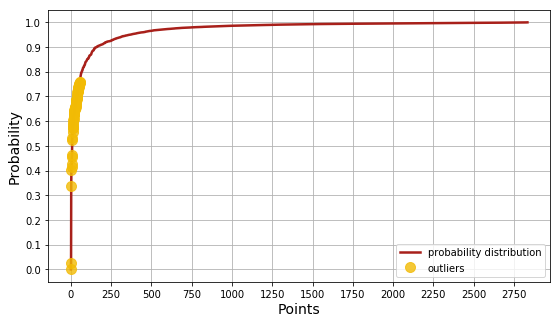

In [19]:
plt.figure(figsize=(9, 5))

plt.plot(np.sort(prob_larger), "-", color = '#A8201A', linewidth=2.5) # All dataset
plt.plot(np.sort(prob_larger[prob_larger<0.76]), "o", markersize=10, alpha=0.8, color = '#F2BB05') # Yellow points = outliers with threshold = 0.79
plt.xlabel("Points", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.xticks(np.arange(0, 2900, 250))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.legend(("probability distribution", "outliers"))

plt.savefig('Images/Outliers/MDprob.png', format='png', bbox_inches='tight')

As we can see only about 150 records out of 2835 have a probability below 90% of being generated by this distribution. On the other hand more than 1500 records have a probability higher than 99%.

We try to plot the dataset also for other combinations of variables to see if there's a scheme in the distribution.

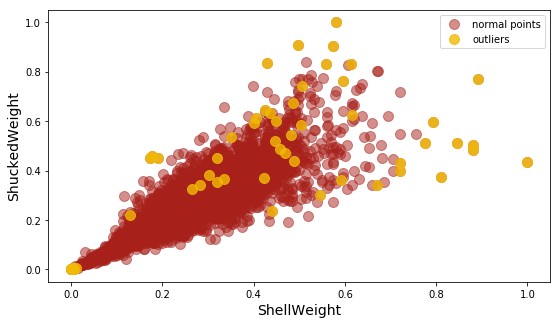

In [20]:
plt.figure(figsize=(9, 5))
plt.plot(df["ShellWeight"], df["ShuckedWeight"], 'o', color = '#A8201A', markersize=10, alpha=0.5)
plt.plot(out_md["ShellWeight"], out_md["ShuckedWeight"], 'o', color = '#F2BB05', markersize=10, alpha=0.8)
plt.xlabel("ShellWeight", fontsize=14)
plt.ylabel("ShuckedWeight", fontsize=14)
plt.legend(("normal points", "outliers"))

plt.savefig('Images/Outliers/MDout.png', format='png', bbox_inches='tight')

## DEPTH BASED APPROACH - CONVEX HULL

We search for outliers at the border of the data space. If we organize data objects in convex hull layers then the outliers are objects in the outer layers.

We can define a function that takes some kind of dataset and performs the analysis. What it does is compute the outer convex hull of the dataset, append to a list the vertices that compose that level, remove those points and restart. The method returns a list where in each position there's the list of points composing each level.

In [21]:
def depth_outliers(dataset):
    depth = list()
    while len(dataset) > 0:
        if len(dataset) > 2:
            hull = ConvexHull(dataset)
            hv = hull.vertices
        else:
            hv = range(len(dataset))
        depth.append(dataset[hv])
        dataset = np.array([ dataset[i] for i in range(len(dataset)) if i not in hv])
    return depth

The problem is that convex hull computation is usually only efficient in 2D / 3D spaces so we have to select a subset of varibles to compute the analysis on.

First of all let's try with Volume and WholeWeight.

In [22]:
points = df[["Volume", "WholeWeight"]]
depth_set = depth_outliers(points.values)

In [23]:
index_out = []
for level in depth_set[0:5]:
    for point in level:
        row = df.index[(df["Volume"]== point[0]) & (df["WholeWeight"]== point[1])].tolist()[0]
        index_out.append(row)
        
index_out = sorted(index_out)
out_hull0 = df.iloc[index_out]

We can plot the result by drawing first the scatter plot of the two variables and then connecting with a line the first 5 hulls. In order to draw the whole circle we have to append the first vertex to each list

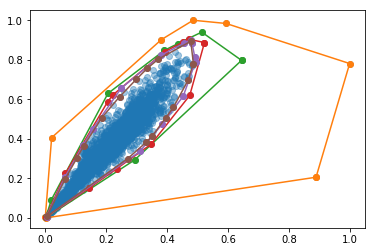

In [24]:
plt.plot(df["Volume"], df["WholeWeight"], 'o', alpha=0.4)

for dd in depth_set[0:5]:
    dd2 = np.append(dd,[dd[0]],axis=0)
    plt.plot(dd2[:,0], dd2[:,1], 'o-')

In [25]:
print "The total number of layers is", len(depth_set)
print "1 - Orange:", len(depth_set[0])
print "2 - Green:", len(depth_set[1])
print "3 - Red:", len(depth_set[2])
print "4 - Purple:", len(depth_set[3])
print "5 - Brown:", len(depth_set[4])
print "The first 5 layers contain", len(out_hull0), "points"

The total number of layers is 114
1 - Orange: 8
2 - Green: 10
3 - Red: 13
4 - Purple: 15
5 - Brown: 17
The first 5 layers contain 63 points


However this result is very dependent from the couple of variables chosen. We can try to select two different ones and compare the results obtained, for example with ShellWeight and ShuckedWeight.

In [26]:
points = df[["ShellWeight", "ShuckedWeight"]]
depth_set = depth_outliers(points.values)

index_out = []
for level in depth_set[0:5]:
    for point in level:
        row = df.index[(df["ShellWeight"]== point[0]) & (df["ShuckedWeight"]== point[1])].tolist()[0]
        index_out.append(row)
        
index_out = sorted(index_out)
out_hull1 = df.iloc[index_out]

len(out_hull1)

67

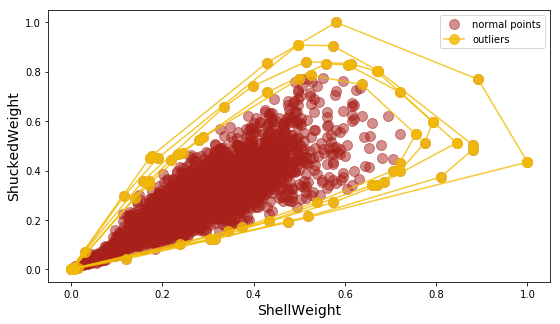

In [27]:
plt.figure(figsize=(9, 5))
plt.plot(df["ShellWeight"], df["ShuckedWeight"], 'o', alpha=0.5, markersize=10, color = '#A8201A')

for dd in depth_set[0:5]:
    dd2 = np.append(dd,[dd[0]],axis=0)
    plt.plot(dd2[:,0], dd2[:,1], 'o-', markersize=10, alpha=0.8, color = '#F2BB05')
    
plt.xlabel("ShellWeight", fontsize=14)
plt.ylabel("ShuckedWeight", fontsize=14)
plt.legend(("normal points", "outliers"))

plt.savefig('Images/Outliers/Hullex.png', format='png', bbox_inches='tight')

So now we define a function to compute just the number of convex hull we require

In [28]:
def outer_hulls(dataset, min_pts):
    depth = list()
    n_out = 0
    while n_out < min_pts:
        if len(dataset) > 2:
            hull = ConvexHull(dataset)
            hv = hull.vertices
        else:
            hv = range(len(dataset))
        depth.append(dataset[hv])
        n_out = n_out+len(dataset[hv])
        dataset = np.array([ dataset[i] for i in range(len(dataset)) if i not in hv])
    return depth

Now that we have a more efficient way to compute just the hulls that we need we can compute it on all the combinations of variables.

So first of all we retrieve the names of our varibles (we remove Sex because it's a binary varible).

In [29]:
columns = list(df.keys())
columns = columns[1:]
print columns

['Length', 'Diameter', 'Height', 'Volume', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings']


We create a copy of the dataframe and we insert a new varible that keeps track of the number of times a point is selected as an outlier.

For each combination of columns we compute the convex hulls that we need, and we retrieve from the dataframe all the points composing it.

In [30]:
df2 = df.copy()
df2["OutCount"] = 0

combinations = comb(columns, 3)
for c in combinations:
    var1 = c[0]
    var2 = c[1]
    var3 = c[2]
    points = df[[var1, var2, var3]]
    depth_set = outer_hulls(points.values, 35)
    index_out = []
    for level in depth_set:
        for point in level:
            row = df.index[(df[var1]== point[0]) & (df[var2]== point[1]) & (df[var3]== point[2])].tolist()[0]
            index_out.append(row)
    index_out = sorted(index_out)
    increase_list = [1] * len(list(df2.loc[index_out]["OutCount"]))
    df2.loc[index_out, "OutCount"] = list(map(add, df2.loc[index_out]["OutCount"], increase_list) )

Now from the column OutCount we retrieve the 2% of points with higher value

In [31]:
print len( df2.loc[df2["OutCount"]>25])
out_hull = df2.loc[df2["OutCount"]>25]
del out_hull["OutCount"]

55


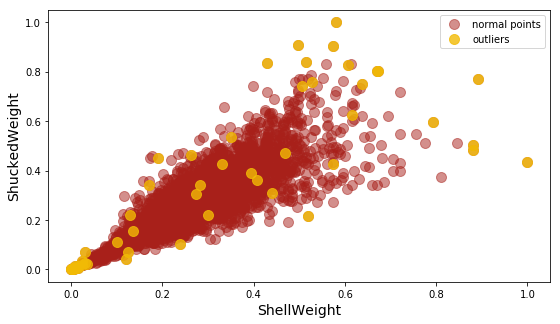

In [32]:
plt.figure(figsize=(9, 5))
plt.plot(df["ShellWeight"], df["ShuckedWeight"], 'o',  markersize=10, color = '#A8201A', alpha=0.5)
plt.plot(out_hull["ShellWeight"], out_hull["ShuckedWeight"], 'o', markersize=10, color = '#F2BB05', alpha=0.8)
plt.xlabel("ShellWeight", fontsize=14)
plt.ylabel("ShuckedWeight", fontsize=14)
plt.legend(("normal points", "outliers"))

plt.savefig('Images/Outliers/Hullout.png', format='png', bbox_inches='tight')

## DISTANCE BASED APPROACH - DB SCAN

The main idea is to judge a point based on the distance to its neighbors. The DBscan is a clustering algorithm that divides the points based on the density of the area they're in. The points that have a dense neighborhood are normal while outliers fall in a less dense area.

The DBscan usually does not perform well in distributions with clear clusters but of different density. It also may have some problems with high dimensional data for the curse of dimensionality.

The algorithm requires to set two parameters in particular: eps, which is the radius of the area surrounding a point, and minPts, which is the minimum number of points to have in the eps-radius to not be considered an outlier. There are several ways to decide how to set them. First of all one can fix one of the two and then take the other in order to have the required number of outliers. However how to choose the first one? In order to make a decision we need more information on our dataset.

So first of all we can compute the distance from each point to its 10 nearest neighbour.

In [33]:
nearest_neighbour = NearestNeighbors(n_neighbors=10)
nearest_neighbour.fit(df)
distances, indices = nearest_neighbour.kneighbors(df)

closest_distance = []

for d in distances:
    closest_distance.append(d[-1])
    
closest_distance = sorted(closest_distance)

We can plot these distances in order to see the majority of points how close are to their 10 nearest neighbour.

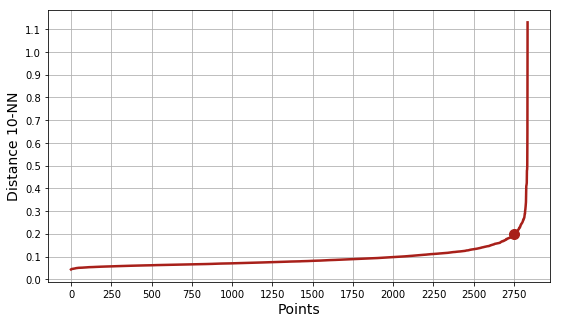

In [34]:
fig = plt.figure(figsize=(9, 5)) 
fig_dims = (1, 1)

ax = plt.subplot2grid(fig_dims, (0, 0))
plt.plot(closest_distance, color = '#A8201A', linewidth=2.5)
plt.plot(2750, 0.2, 'o', color='#A8201A', markersize=10)
plt.xticks(np.arange(0, 3000, 250))
plt.yticks(np.arange(0, 1.2, 0.10))
plt.xlabel("Points", fontsize=14)
plt.ylabel("Distance 10-NN", fontsize=14)
plt.grid(True)

plt.savefig('Images/Outliers/DBeps.png', format='png', bbox_inches='tight')

So from this plot we can see that there's a knee. So if we take eps as 0.2 the 99% of values has at least 2 neighbours below 0.2 distance.

Once fixed eps=0.2 we can calculate for each point how many points are contained in its eps-neighborhood.

In [35]:
points = spatial.cKDTree(df)

In [36]:
number_of_points = points.query_ball_point(df, 0.2)

In [37]:
n_points = []
for i in number_of_points:
    n_points.append(len(i))

In [38]:
n_points = sorted(n_points)

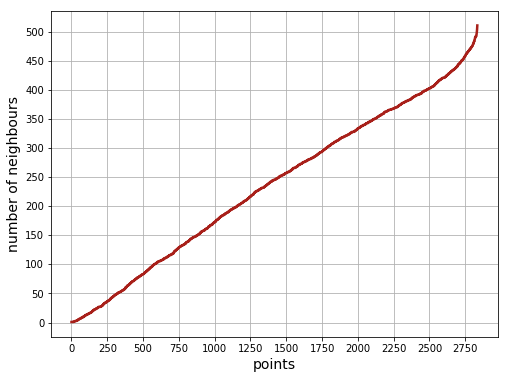

In [39]:
fig = plt.figure(figsize=(8, 6)) 
fig_dims = (1, 1)

ax = plt.subplot2grid(fig_dims, (0, 0))
plt.plot(n_points, color = '#A8201A', linewidth=2.5)
plt.xticks(np.arange(0, 3000, 250))
plt.yticks(np.arange(0, 550, 50))
ax.set_xlabel("points", fontsize=14)
ax.set_ylabel("number of neighbours", fontsize=14)
plt.grid(True)

From this graph we can see that just about 300 points out of 2835 have less than 50 neighbours in 0.2 distance.

So if we want the top 60 outliers we can search for points that have less than 30 neighbour in 0.2 distance.

In [62]:
dbscan = DBSCAN(0.2, min_samples=25, metric='euclidean')
dbscan.fit(df)
labels = dbscan.labels_

In [41]:
out_db = df.loc[labels == -1]
print len(out_db)

55


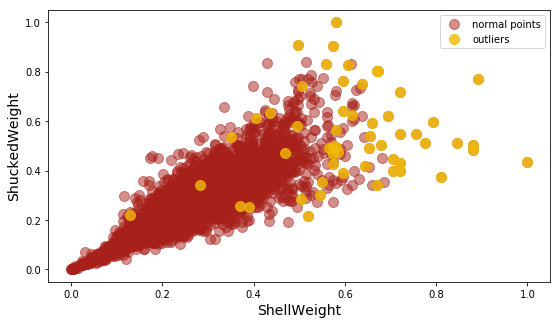

In [42]:
plt.figure(figsize=(9, 5))
plt.plot(df["ShellWeight"], df["ShuckedWeight"], 'o', markersize=10, color = '#A8201A', alpha=0.5)
plt.plot(out_db["ShellWeight"], out_db["ShuckedWeight"], 'o', markersize=10, color = '#F2BB05', alpha=0.8)
plt.xlabel("ShellWeight", fontsize=14)
plt.ylabel("ShuckedWeight", fontsize=14)
plt.legend(("normal points", "outliers"))

plt.savefig('Images/Outliers/DBout.png', format='png', bbox_inches='tight')

An alternative way to get the same result, it's to fix the number of minimum points to 30 and then look for the appropriate number for eps.

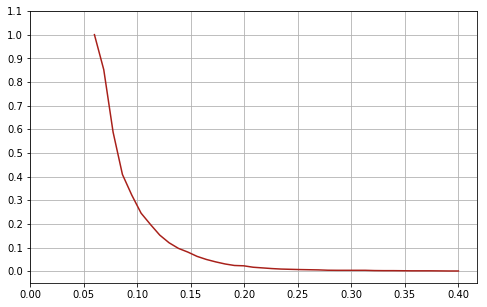

In [43]:
fig = plt.figure(figsize=(8, 5)) 

xx = np.linspace(0.06, 0.4, 40)
yy = list()
for eps in xx:
    dbscan = DBSCAN(eps, min_samples=30, metric='euclidean')
    dbscan.fit(df)
    labels = dbscan.labels_
    yy.append(float(len([1 for i in labels if i == -1])) / len(df))
    
plt.plot(xx, yy, color = '#A8201A')
ax.set_xlabel("eps", fontsize=14)
ax.set_ylabel("noise", fontsize=14)
plt.xticks(np.arange(0, 0.45, 0.05))
plt.yticks(np.arange(0, 1.2, 0.1))
plt.grid(True)

Select eps in order to have less then 2% noise/outliers

In [44]:
my_eps = min( [ xx[i] for i in range(len(xx)) if yy[i]<0.02 ] )
print my_eps

0.208205128205


## DENSITY BASED APPROACH - LOF

The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

Others distance-based outlier detection models have problems if the dataset has different densities.

The number of neighbors considered, (parameter n_neighbors) is typically chosen:
- greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster
- smaller than the maximum number of close by objects that can potentially be local outliers.

In [45]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
y_pred = clf.fit_predict(df)

In [46]:
out_lof = df.loc[y_pred == -1]
print len(out_lof)

57


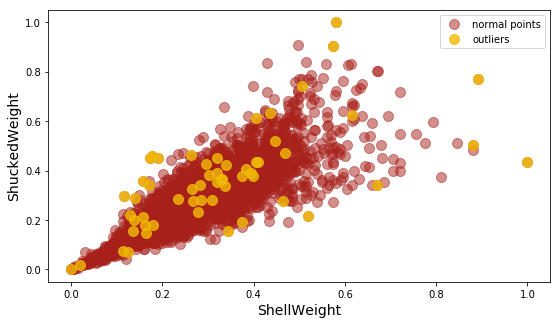

In [47]:
plt.figure(figsize=(9, 5))
plt.plot(df["ShellWeight"], df["ShuckedWeight"], 'o', markersize=10, color = '#A8201A', alpha=0.5)
plt.plot(out_lof["ShellWeight"], out_lof["ShuckedWeight"], 'o', markersize=10, color = '#F2BB05', alpha=0.8)
plt.xlabel("ShellWeight", fontsize=14)
plt.ylabel("ShuckedWeight", fontsize=14)
plt.legend(("normal points", "outliers"))

plt.savefig('Images/Outliers/LOFout.png', format='png', bbox_inches='tight')

We create two new color maps to show better our results

In [48]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

hotBar = truncate_colormap(plt.get_cmap('hot'), 0.05, 0.92)
hot1 = truncate_colormap(plt.get_cmap('hot'), 0.55, 0.95)
hot2 = truncate_colormap(plt.get_cmap('hot'), 0.05, 0.8)


Since it's an algorithm that assigns a score to each point, we can draw a color map rappresenting the outlier-score of each point. In this case the colors closer to yellow represent higher values and hence points that are more likely to be outliers.

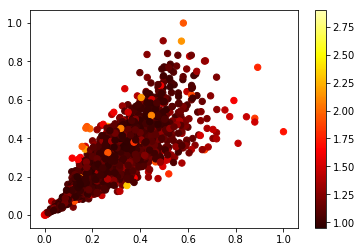

In [49]:
df2 = df.copy()
df2 = df2[df2.Height < 0.4]

clf = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
y_pred = clf.fit_predict(df2)

plt.scatter(df2["ShellWeight"], df2["ShuckedWeight"], s=40, c= -clf.negative_outlier_factor_, cmap=hotBar)
plt.colorbar()

Another thing we can visualize is the density of the entire point space. The darker pink shows the less dense areas

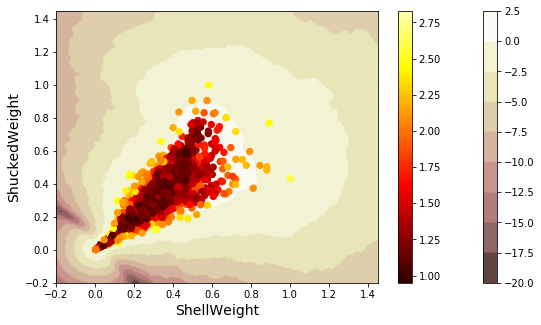

In [50]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
y_pred = clf.fit_predict(df[["ShellWeight", "ShuckedWeight"]])

area_lof = df.loc[y_pred == -1]

#we create a grid of points for the whole area
xx, yy = np.meshgrid(np.linspace(-0.2, 1.45, 100), np.linspace(-0.2, 1.45, 100))
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#we draw the background 
plt.figure(figsize=(9, 5))
plt.contourf(xx, yy, Z, cmap="pink", alpha=0.9)
plt.colorbar()

#we draw the scatter plot with the colors according to the LOF score just to have the legend of the colors
plt.scatter(df["ShellWeight"], df["ShuckedWeight"], s=10, c= -clf.negative_outlier_factor_, cmap=hotBar)
plt.colorbar()

#we draw the scatter plot above again but now we first draw the score values in red for normal points and then 
#in yellow with the rest of the color map the outliers. This way is easier to see the outliers
df1 = df.copy()
df1["LOF"] = - clf.negative_outlier_factor_

dfA = df1[df1["LOF"] < 1.4]
dfB = df1[df1["LOF"] >= 1.4]
plt.scatter(dfA["ShellWeight"], dfA["ShuckedWeight"], s=40, c=dfA["LOF"], cmap=hot2)
plt.scatter(dfB["ShellWeight"], dfB["ShuckedWeight"], s=40, c=dfB["LOF"], cmap=hot1)

plt.xlabel("ShellWeight", fontsize=14)
plt.ylabel("ShuckedWeight", fontsize=14)

plt.savefig('Images/Outliers/LOFarea.png', format='png', bbox_inches='tight')

## HIGH DIMENSIONAL APPROACHES - ABOD

ABOD is an Angle Based Outlier Degree method that is very useful when dealing with high dimensional data. Indeed there might be the curse of dimensionality, hence the relative contrast between distances decreases with increasing dimensionality, so according to the distribution data may seem as all outliers or as all one cluster. 

In high dimensional spaces angles are more stable than distances. The basic assumption is that outliers are located at the border of the data distribution, while normal points are in the center. So an object is an outlier if most other objects in the dataset are located in similar directions.

We can compute ABOD score for each point, the top 1% with lower scores are considered outliers. The computation is very slow as it is $ O(n^3) $ .

Instead we use the library of pyod that already has this method and it allows to choose the fast version, that instead of searching the angle with the whole dataset just takes the k-nn of the point.

In [51]:
ab = ABOD(contamination=0.02, n_neighbors=10, method='fast')
ab.fit(df)

ABOD(contamination=0.02, method='fast', n_neighbors=10)

In [52]:
abod_pred = ab.labels_ 

In [53]:
out_abod = df.loc[abod_pred == 1]
len(out_abod)

57

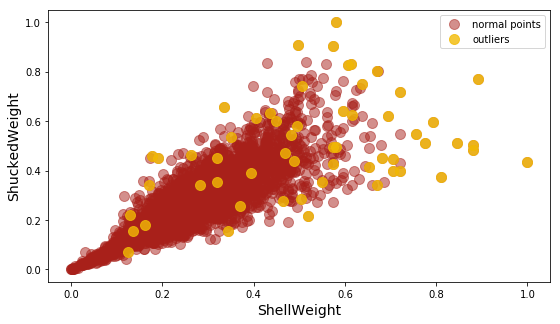

In [54]:
plt.figure(figsize=(9, 5))
plt.plot(df["ShellWeight"], df["ShuckedWeight"], 'o', markersize=10, color = '#A8201A', alpha=0.5)
plt.plot(out_abod["ShellWeight"], out_abod["ShuckedWeight"], 'o', markersize=10, color = '#F2BB05', alpha=0.8)
plt.xlabel("ShellWeight", fontsize=14)
plt.ylabel("ShuckedWeight", fontsize=14)
plt.legend(("normal points", "outliers"))

plt.savefig('Images/Outliers/ABODout.png', format='png', bbox_inches='tight')

As we did for LOF score we can draw the color map representing the ABOD score. Since the values of the outliers are very hight we take the log version. A higher value means a higher probability of being an outlier.

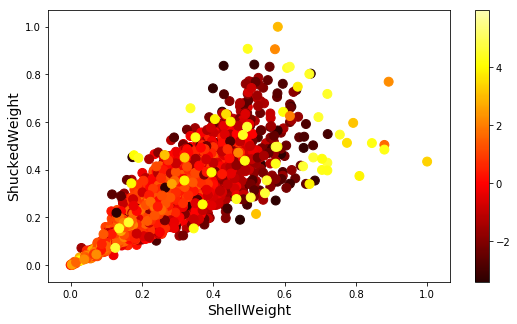

In [55]:
clf = ABOD(contamination=0.02, n_neighbors=10, method='fast')
y_pred = clf.fit_predict(df)

plt.figure(figsize=(9, 5))

#we draw the scatter plot with the colors according to the LOF score just to have the legend of the colors
plt.scatter(df["ShellWeight"], df["ShuckedWeight"], s=10, c= np.log10(np.abs(clf.decision_scores_)), cmap=hotBar)
plt.colorbar()

#we draw the scatter plot above again but now we first draw the score values in red for normal points and then 
#in yellow with the rest of the color map the outliers. This way is easier to see the outliers
df1 = df.copy()
df1["ABOD"] = np.log10(np.abs(clf.decision_scores_))

dfA = df1[df1["ABOD"] >1.8]
dfB = df1[df1["ABOD"] <= 1.8]
plt.scatter(dfA["ShellWeight"], dfA["ShuckedWeight"], s=80, c=dfA["ABOD"], cmap=hot2)
plt.scatter(dfB["ShellWeight"], dfB["ShuckedWeight"], s=80, c=dfB["ABOD"], cmap=hot2)

plt.xlabel("ShellWeight", fontsize=14)
plt.ylabel("ShuckedWeight", fontsize=14)

plt.savefig('Images/Outliers/ABODscore.png', format='png', bbox_inches='tight')

The distribution of the ABOD score. It ranges from 0 to almost 1 million.

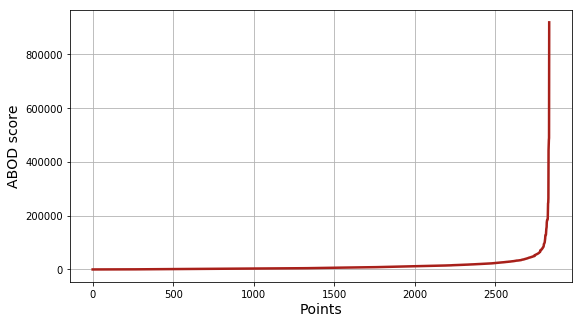

In [56]:
fig = plt.figure(figsize=(9, 5)) 
fig_dims = (1, 1)

ax = plt.subplot2grid(fig_dims, (0, 0))
plt.plot(sorted(-clf.decision_scores_), color = '#A8201A', linewidth=2.5)
# plt.xticks(np.arange(0, 3000, 250))
# plt.yticks(np.arange(0, 1000000, 100000))
plt.xlabel("Points", fontsize=14)
plt.ylabel("ABOD score", fontsize=14)
plt.grid(True)

# COMPARISON OF THE RESULTS

We can count for each point how many methods think it's an outlier.

In [57]:
df2 = df.copy()
df2["OutCount"] = 0

increase_list = [1] * len(out_md)
df2.loc[out_md.index.values, "OutCount"] = list(map(add, df2.loc[out_md.index.values, "OutCount"], increase_list) )

increase_list = [1] * len(out_hull)
df2.loc[out_hull.index.values, "OutCount"] = list(map(add, df2.loc[out_hull.index.values, "OutCount"], increase_list) )

increase_list = [1] * len(out_db)
df2.loc[out_db.index.values, "OutCount"] = list(map(add, df2.loc[out_db.index.values, "OutCount"], increase_list) )

increase_list = [1] * len(out_lof)
df2.loc[out_lof.index.values, "OutCount"] = list(map(add, df2.loc[out_lof.index.values, "OutCount"], increase_list) )

increase_list = [1] * len(out_abod)
df2.loc[out_abod.index.values, "OutCount"] = list(map(add, df2.loc[out_abod.index.values, "OutCount"], increase_list) )

In [58]:
print "points that no method considers as an outlier", len(df2.loc[df2["OutCount"]==0])
print "points validated as outliers by 1 methods", len(df2.loc[df2["OutCount"]==1])
print "points validated as outliers by 2 methods", len(df2.loc[df2["OutCount"]==2])
print "points validated as outliers by 3 methods", len(df2.loc[df2["OutCount"]==3])
print "points validated as outliers by 4 methods", len(df2.loc[df2["OutCount"]==4])
print "points validated as outliers by 5 methods", len(df2.loc[df2["OutCount"]==5])
real_out = df2.loc[df2["OutCount"]>=3]

points that no method considers as an outlier 2693
points validated as outliers by 1 methods 68
points validated as outliers by 2 methods 38
points validated as outliers by 3 methods 17
points validated as outliers by 4 methods 9
points validated as outliers by 5 methods 10


Now we can count how many of those outliers are found by each method (consider however that the methods found each the 2% of outliers, hence 57 points)

In [59]:
print "MD found", len(real_out.merge(out_md)), "outliers out of 36"
print "hull found", len(real_out.merge(out_hull)), "outliers out of 36"
print "DB found", len(real_out.merge(out_db)), "outliers out of 36"
print "Lof found", len(real_out.merge(out_lof)), "outliers out of 36"
print "ABOD found", len(real_out.merge(out_abod)), "outliers out of 36"

MD found 26 outliers out of 36
hull found 26 outliers out of 36
DB found 26 outliers out of 36
Lof found 24 outliers out of 36
ABOD found 35 outliers out of 36


Or as a percentage:

In [60]:
print "MD found", round(len(real_out.merge(out_md))/float(36), 4), "% of outliers"
print "hull found",  round(len(real_out.merge(out_hull))/float(36), 4), "% of outliers"
print "DB found",  round(len(real_out.merge(out_db))/float(36), 4), "% of outliers"
print "Lof found",  round(len(real_out.merge(out_lof))/float(36), 4), "% of outliers"
print "ABOD found",  round(len(real_out.merge(out_abod))/float(36), 4), "% of outliers"

MD found 0.7222 % of outliers
hull found 0.7222 % of outliers
DB found 0.7222 % of outliers
Lof found 0.6667 % of outliers
ABOD found 0.9722 % of outliers


So, if we want 1% of outliers we can take points validated by at least 3 methods, hence 36 points.

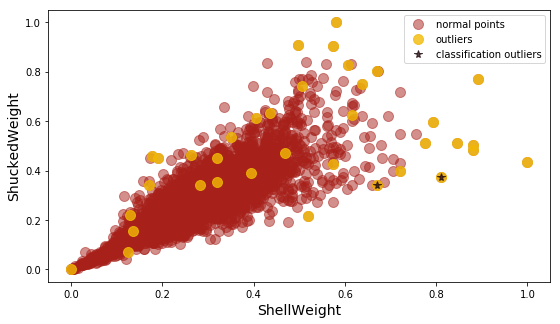

In [70]:
plt.figure(figsize=(9, 5))

plt.plot(df["ShellWeight"], df["ShuckedWeight"], 'o', markersize=10, color = '#A8201A', alpha=0.5)
plt.plot(real_out["ShellWeight"], real_out["ShuckedWeight"], 'o', markersize=10, color = '#F2BB05', alpha=0.8)
plt.plot(df["ShellWeight"].iloc[993], df["ShuckedWeight"].iloc[993], "*", color = '#230C0F', markersize=8, alpha=0.8)
plt.plot(df["ShellWeight"].iloc[1371], df["ShuckedWeight"].iloc[1371], "*", color = '#230C0F', markersize=8, linewidth = 4, alpha=0.8)

plt.xlabel("ShellWeight", fontsize=14)
plt.ylabel("ShuckedWeight", fontsize=14)
plt.legend(("normal points", "outliers", "classification outliers"))

plt.savefig('Images/Outliers/RESULTSout.png', format='png', bbox_inches='tight')

As we can see the two points with very big Height that were removed in the classification are confirmed to be outliers.

Now we take the list of indices of points that where misclassified by the ANN and we see if there's an intersection with the outliers.

In [68]:
indices_wrongANN = [3, 6, 9, 11, 13, 15, 19, 21, 22, 26, 29, 35, 38, 40, 42, 44, 48, 54, 56, 65, 69, 75, 78, 79, 89, 93, 95,
 96, 102, 103, 108, 112, 117, 118, 124, 127, 130, 135, 136, 140, 145, 148, 151, 155, 156, 158, 159, 163, 167, 171,
 183, 186, 187, 190, 191, 192, 193, 195, 196, 197, 205, 209, 214, 216, 219, 221, 224, 230, 243, 247, 249, 256, 257,
 274, 278, 280, 282, 283, 284, 288, 298, 299, 306, 309, 310, 313, 318, 319, 327, 328, 330, 337, 339, 351, 356, 359,
 361, 369, 371, 372, 374, 377, 382, 383, 385, 387, 388, 391, 399, 406, 408, 409, 419, 422, 425, 436, 438, 441, 443,
 446, 447, 451, 456, 457, 458, 462, 463, 464, 467, 480, 484, 489, 494, 496, 499, 500, 502, 503, 509, 510, 513, 514,
 516, 517, 518, 524, 526, 529, 535, 542, 545, 546, 553, 560, 562, 565, 578, 584, 587, 588, 590, 596, 602, 606, 608,
 613, 615, 620, 621, 627, 630, 636, 643, 644, 646, 656, 659, 664, 666, 671, 674, 675, 676, 681, 684, 689, 695, 703,
 707, 708, 711, 712, 714, 719, 721, 722, 729, 731, 738, 741, 747, 750, 754, 756, 759, 762, 764, 772, 776, 780, 782,
 794, 796, 798, 800, 802, 807, 812, 817, 818, 824, 826, 827, 831, 834, 836, 838, 845, 847, 848]

indices_out = real_out.index.tolist()

In [69]:
list(set(indices_wrongANN) & set(indices_out))

[140, 69]

There are just 2 outliers that were misclassified by ANN, it's not significant